# Proyecto 2
Ariela Mishaan (22052), Alina Carías (22539), Diego Soto (22737), Ignacio Méndez (22613) y Marcos Díaz

## Librerias

In [1]:
import os
import json
import gc
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

## Carga de datos

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:

file_path = "/kaggle/input/asl-fingerspelling/train_landmarks/1019715464.parquet" 
df = pd.read_parquet(file_path)

## Preprocesamiento

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 1. Detectar columnas de coordenadas
x_cols = [c for c in df.columns if c.startswith("x_")]
y_cols = [c for c in df.columns if c.startswith("y_")]
z_cols = [c for c in df.columns if c.startswith("z_")]
coord_cols = x_cols + y_cols + z_cols

only_nan_cols = df[coord_cols].columns[df[coord_cols].isna().all()]
print(f"Columnas completamente vacías: {len(only_nan_cols)}")
df = df.drop(columns=only_nan_cols)

print(f"Total coordenadas: {len(coord_cols)} | x: {len(x_cols)} | y: {len(y_cols)} | z: {len(z_cols)}")

# 2. Reemplazar todos los NaNs con 0 (por ahora)
df[coord_cols] = df[coord_cols].fillna(0)

# 3. Normalizar todas las coordenadas a rango [0, 1]
scaler = MinMaxScaler()
df[coord_cols] = scaler.fit_transform(df[coord_cols])

print("✅ Limpieza completada: NaNs → 0 y coordenadas normalizadas en [0, 1]")


Columnas completamente vacías: 0
Total coordenadas: 1629 | x: 543 | y: 543 | z: 543
✅ Limpieza completada: NaNs → 0 y coordenadas normalizadas en [0, 1]


## Exploración

In [ ]:
#dataset_df.head()
df.shape, df.head()

Cada entrada en el train tiene el nombre del archivo (path), el id del archivo (file_id), el id de la sequencia o la oración (sequence_id), el id del participante (participant_id) y la frase que se representa con el lenguaje de señas (phrase). El file_id indica el archivo que tiene la data de los landmarks para cada frase y el sequence_id es el indice unico de una secuencia dentro de cada archivo de landmarks. 

In [ ]:
columnas = df.columns.tolist()
print(columnas)

68 documentos de train landmarks
* x_face 467 columnas
* x_left_hand 20 columnas
* x_pose 32 columnas
* x_right_hand 20 columnas
* y_face 467 columnas
* y_left_hand 20 columnas
* y_pose 32 columnas
* y_right_hand 20 columnas
* z_face 467 columnas
* z_left_hand 20 columnas
* z_pose 32 columnas
* z_right_hand 20 columnas


In [8]:
print(df.shape)
print(df.isna().sum().sum())  # total de NaNs
print(df.isna().sum()[df.isna().sum() > 0])  # columnas específicas


(161461, 1630)
0
Series([], dtype: int64)


In [12]:
import re
import matplotlib.pyplot as plt

def cols_by_prefix(df, prefix):
    """Devuelve columnas con el prefijo + número final, ordenadas numéricamente."""
    patt = re.compile(rf'^{re.escape(prefix)}(\d+)$')  # busca por ejemplo 'x_left_hand_12'
    pairs = []
    for c in df.columns:
        m = patt.match(c)
        if m:
            pairs.append((int(m.group(1)), c))
    pairs.sort(key=lambda x: x[0])
    return [c for _, c in pairs]

def get_frame_row(df, frame=0):
    """Devuelve una única fila correspondiente al frame deseado."""
    frame_cols = [c for c in df.columns if c.lower() in ("frame","frame_idx","frame_index","frame_id")]
    if frame_cols:
        col = frame_cols[0]
        row = df.loc[df[col] == frame].iloc[0]
    else:
        row = df.iloc[frame]
    return row

def plot_hand(df, frame=0, hand='left'):
    """Grafica 21 puntos de la mano izquierda o derecha en un frame dado."""
    x_cols = cols_by_prefix(df, f'x_{hand}_hand_')
    y_cols = cols_by_prefix(df, f'y_{hand}_hand_')
    
    if len(x_cols) != 21 or len(y_cols) != 21:
        print(f"⚠️ Esperaba 21 columnas para mano {hand}, pero encontré {len(x_cols)} (x) y {len(y_cols)} (y)")
        return

    row = get_frame_row(df, frame)
    x = row[x_cols].to_numpy()
    y = row[y_cols].to_numpy()

    plt.figure(figsize=(4, 4))
    plt.scatter(x, 1 - y, s=40)  # 1 - y si normalizado, para no salir invertido
    plt.title(f"Mano {hand} - Frame {frame}")
    plt.axis("off")
    plt.show()

    print(f"✅ Graficados {len(x)} puntos para mano {hand} en frame {frame}")

import matplotlib.pyplot as plt

# Estructura de conexiones de la mano (MediaPipe)
CONEXIONES_MANO = [
    (0, 1), (1, 2), (2, 3), (3, 4),       # pulgar
    (0, 5), (5, 6), (6, 7), (7, 8),       # índice
    (0, 9), (9,10), (10,11), (11,12),     # medio
    (0,13), (13,14), (14,15), (15,16),    # anular
    (0,17), (17,18), (18,19), (19,20)     # meñique
]

def plot_hand_conectado(df, frame=0, hand='left'):
    """Grafica la mano conectando los puntos entre sí (estilo esqueleto)"""
    x_cols = [f"x_{hand}_hand_{i}" for i in range(21)]
    y_cols = [f"y_{hand}_hand_{i}" for i in range(21)]

    # Obtener coordenadas del frame deseado
    row = df.iloc[frame]
    x = row[x_cols].values
    y = row[y_cols].values

    # Invertimos Y si ya está normalizado a [0,1]
    y = 1 - y

    plt.figure(figsize=(4, 4))
    
    # Dibujar conexiones entre puntos
    for i, j in CONEXIONES_MANO:
        plt.plot([x[i], x[j]], [y[i], y[j]], color='blue', linewidth=2)

    # Dibujar puntos
    plt.scatter(x, y, color='red', s=40)
    plt.title(f"Mano {hand.capitalize()} - Frame {frame}")
    plt.axis('off')
    plt.show()



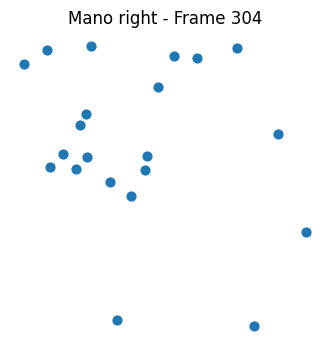

✅ Graficados 21 puntos para mano right en frame 304


In [22]:
plot_hand(df, frame=304, hand='right')


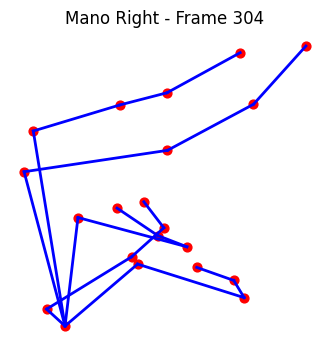

In [23]:

plot_hand_conectado(df, frame=304, hand="right")


In [ ]:
archivo = '/Users/arielamishaancohen/Downloads/asl-fingerspelling/supplemental_landmarks/86446671.parquet'

# Leer el archivo parquet
df = pd.read_parquet(archivo)
# Mostrar las primeras filas
df.head()

In [ ]:
print(list(df.columns))

Cada archivo parquet contiene una frase dividida en frames, cada frame es una fila, en las columnas se encuentra la información de las coordenadas. 

In [6]:
# ==========================================
# ASL 3D VIS (auto-selección de parte y filtros NaN)
# ==========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

# -----------------------------
# (A) Carga de datos
# -----------------------------
USE_EXISTING_DATAFRAME = 'data' in globals()

if not USE_EXISTING_DATAFRAME:
    PARQUET_PATH = "/kaggle/input/asl-fingerspelling/train_landmarks/1019715464.parquet"  # <-- CAMBIA ESTA RUTA
    data = pd.read_parquet(PARQUET_PATH)

if 'sequence_id' not in data.columns:
    data = data.reset_index()

# Selecciona una secuencia (la primera por defecto)
seq_id = data["sequence_id"].iloc[0]
seq = data[data["sequence_id"] == seq_id].reset_index(drop=True)

# -----------------------------
# (B) Conexiones Mediapipe
# -----------------------------
HAND_CONNECTIONS = [
    (0, 1), (1, 2), (2, 3), (3, 4),
    (0, 5), (5, 6), (6, 7), (7, 8),
    (5, 9), (9, 10), (10, 11), (11, 12),
    (9, 13), (13, 14), (14, 15), (15, 16),
    (13, 17), (17, 18), (18, 19), (19, 20),
    (0, 17)
]
FACE_CONNECTIONS = [
    (33, 133), (362, 263), (61, 291), (0, 17), (78, 308)
]
POSE_CONNECTIONS = [
    (11, 12),
    (11, 13), (13, 15),
    (12, 14), (14, 16),
    (11, 23), (12, 24),
    (23, 24), (23, 25), (24, 26)
]
N_POINTS = {"right_hand": 21, "left_hand": 21, "pose": 33, "face": 468}
CONNS = {"right_hand": HAND_CONNECTIONS, "left_hand": HAND_CONNECTIONS,
         "pose": POSE_CONNECTIONS, "face": FACE_CONNECTIONS}
COLPREFIXES = {
    "right_hand": ("x_right_hand_", "y_right_hand_", "z_right_hand_"),
    "left_hand":  ("x_left_hand_",  "y_left_hand_",  "z_left_hand_"),
    "pose":       ("x_pose_",       "y_pose_",       "z_pose_"),
    "face":       ("x_face_",       "y_face_",       "z_face_"),
}

# -----------------------------
# (C) Funciones utilitarias
# -----------------------------
def extract_landmarks(row: pd.Series, part: str, n_points: int):
    """Devuelve arrays (xs, ys, zs) con NaNs donde falten columnas."""
    xs, ys, zs = [], [], []
    for i in range(n_points):
        x_col, y_col, z_col = f"{COLPREFIXES[part][0]}{i}", f"{COLPREFIXES[part][1]}{i}", f"{COLPREFIXES[part][2]}{i}"
        if (x_col in row) and (y_col in row) and (z_col in row):
            xs.append(row[x_col]); ys.append(row[y_col]); zs.append(row[z_col])
        else:
            xs.append(np.nan); ys.append(np.nan); zs.append(np.nan)
    return np.array(xs), np.array(ys), np.array(zs)

def count_valid_in_row(row: pd.Series, part: str) -> int:
    xs, ys, zs = extract_landmarks(row, part, N_POINTS[part])
    valid = np.isfinite(xs) & np.isfinite(ys) & np.isfinite(zs)
    return int(valid.sum())

def part_total_valid(seq: pd.DataFrame, part: str) -> int:
    # Rápido: suma de válidos sobre N frames (método vectorizado simple)
    total = 0
    for idx in range(len(seq)):
        total += count_valid_in_row(seq.iloc[idx], part)
    return total

def draw_connections(ax, xs, ys, zs, connections, color="k"):
    for i, j in connections:
        if i < len(xs) and j < len(xs):
            if (np.isfinite(xs[i]) and np.isfinite(ys[i]) and np.isfinite(zs[i]) and
                np.isfinite(xs[j]) and np.isfinite(ys[j]) and np.isfinite(zs[j])):
                ax.plot([xs[i], xs[j]], [ys[i], ys[j]], [zs[i], zs[j]], color=color, linewidth=1)

def plot_landmarks_subplot(ax, row, part, color, title, axis_bounds=None):
    xs, ys, zs = extract_landmarks(row, part, N_POINTS[part])
    mask = np.isfinite(xs) & np.isfinite(ys) & np.isfinite(zs)
    if mask.any():
        ax.scatter(xs[mask], ys[mask], zs[mask], c=color, s=20)
    draw_connections(ax, xs, ys, zs, CONNS[part], color=color)
    ax.set_title(title)
    if axis_bounds and part in axis_bounds:
        (xmin, xmax), (ymin, ymax), (zmin, zmax) = axis_bounds[part]
        ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax); ax.set_zlim(zmin, zmax)
    else:
        # fallback razonable
        ax.set_xlim(0, 1); ax.set_ylim(0, 1); ax.set_zlim(-1, 1)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])

# --- reemplaza tu compute_axis_bounds por este ---
def compute_axis_bounds(seq: pd.DataFrame, parts):
    """
    Calcula límites de ejes por parte a partir de todos los frames.
    Omite partes que no tengan columnas o datos finitos.
    """
    bounds = {}
    for part in parts:
        if part not in N_POINTS or part not in COLPREFIXES:
            continue  # parte desconocida
        xs_all, ys_all, zs_all = [], [], []
        for idx in range(len(seq)):
            xs, ys, zs = extract_landmarks(seq.iloc[idx], part, N_POINTS[part])
            xs_all.append(xs); ys_all.append(ys); zs_all.append(zs)
        xs_all = np.concatenate(xs_all) if xs_all else np.array([])
        ys_all = np.concatenate(ys_all) if ys_all else np.array([])
        zs_all = np.concatenate(zs_all) if zs_all else np.array([])
        mask = np.isfinite(xs_all) & np.isfinite(ys_all) & np.isfinite(zs_all)
        if mask.any():
            xsel, ysel, zsel = xs_all[mask], ys_all[mask], zs_all[mask]
            def rng(a):
                lo, hi = np.nanmin(a), np.nanmax(a)
                if not np.isfinite(lo) or not np.isfinite(hi) or lo == hi:
                    return (0, 1)
                pad = 0.05 * (hi - lo)
                return (lo - pad, hi + pad)
            bounds[part] = (rng(xsel), rng(ysel), rng(zsel))
    return bounds


# -----------------------------
# (D) Diagnóstico y selección automática de parte a filtrar
# -----------------------------
parts_consider = ["left_hand", "right_hand", "pose", "face"]
totals = {p: part_total_valid(seq, p) for p in parts_consider}
print("Puntos válidos totales por parte en la secuencia:")
for p, t in totals.items():
    print(f"  {p:>10}: {t}")

# Elige la parte con mayor cantidad de puntos válidos
PART_TO_CHECK = max(totals, key=totals.get)
print(f"\nParte seleccionada para filtrar: {PART_TO_CHECK}")

# Umbral relativo (20% de puntos de esa parte), al menos 1
MIN_VALID_POINTS = max(1, int(0.2 * N_POINTS[PART_TO_CHECK]))
print(f"Umbral min_valid: {MIN_VALID_POINTS} (de {N_POINTS[PART_TO_CHECK]} puntos posibles)")

# Filtra frames; si ninguno pasa, NO filtra (evita ValueError)
mask = seq.apply(lambda r: count_valid_in_row(r, PART_TO_CHECK) >= MIN_VALID_POINTS, axis=1)
if mask.any():
    seq = seq[mask].reset_index(drop=True)
    print(f"Frames tras filtro: {len(seq)}")
else:
    print("Advertencia: ningún frame cumple el umbral; se continuará SIN filtrar.")
    # no modificamos 'seq'

# -----------------------------
# (E) Parámetros de dibujo
# -----------------------------
DRAW_FACE = True  # True si quieres dibujar cara también
FPS = 10
INTERVAL_MS = int(1000 / FPS)

# Límites de ejes (por datos)
parts_for_bounds = ("right_hand", "left_hand", "pose") + (("face",) if DRAW_FACE else tuple())

# --- calcular bounds una sola vez ---
axis_bounds = compute_axis_bounds(seq, parts=parts_for_bounds)

# -----------------------------
# (F) Animación
# -----------------------------
fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(221, projection="3d")
ax2 = fig.add_subplot(222, projection="3d")
ax3 = fig.add_subplot(223, projection="3d")
ax4 = fig.add_subplot(224, projection="3d")

def update(frame_idx):
    row = seq.iloc[frame_idx]
    for ax in (ax1, ax2, ax3, ax4):
        ax.cla()

    plot_landmarks_subplot(ax1, row, "right_hand", "red",   "Right Hand", axis_bounds)
    plot_landmarks_subplot(ax2, row, "left_hand",  "blue",  "Left Hand",  axis_bounds)

    if DRAW_FACE:
        plot_landmarks_subplot(ax3, row, "face",       "green",  "Face", axis_bounds)
    else:
        ax3.set_title("Face (omitida)"); ax3.set_axis_off()

    plot_landmarks_subplot(ax4, row, "pose",       "orange", "Pose", axis_bounds)

    fig.suptitle(f"Seq {seq_id} · Frame {frame_idx+1}/{len(seq)}", fontsize=16)

anim = FuncAnimation(fig, update, frames=len(seq), interval=INTERVAL_MS)

# -----------------------------
# (G) Guardar GIF
# -----------------------------
OUTPUT_GIF = "asl_sequence.gif"
anim.save(OUTPUT_GIF, writer=PillowWriter(fps=FPS))
plt.close()
print(f"GIF guardado: {OUTPUT_GIF}")


Puntos válidos totales por parte en la secuencia:
   left_hand: 0
  right_hand: 441
        pose: 4191
        face: 59436

Parte seleccionada para filtrar: face
Umbral min_valid: 93 (de 468 puntos posibles)
Frames tras filtro: 127
GIF guardado: asl_sequence.gif


In [9]:
# ==========================================
# ASL 2D GIF (manos + pose; opcional cara) con filtros NaN
# Basado en tu código 3, pero en 2D (x,y) y sin dependencias extra.
# ==========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

# -----------------------------
# (A) Carga de datos
# -----------------------------
USE_EXISTING_DATAFRAME = 'data' in globals()

if not USE_EXISTING_DATAFRAME:
    PARQUET_PATH = "/kaggle/input/asl-fingerspelling/train_landmarks/1019715464.parquet"  # <<-- CAMBIA ESTA RUTA
    data = pd.read_parquet(PARQUET_PATH)

if 'sequence_id' not in data.columns:
    data = data.reset_index()

# Selecciona una secuencia (la primera por defecto)
seq_id = data["sequence_id"].iloc[0]
seq = data[data["sequence_id"] == seq_id].reset_index(drop=True)

# -----------------------------
# (B) Conexiones Mediapipe
# -----------------------------
HAND_CONNECTIONS = [
    (0, 1), (1, 2), (2, 3), (3, 4),          # pulgar
    (0, 5), (5, 6), (6, 7), (7, 8),          # índice
    (5, 9), (9, 10), (10, 11), (11, 12),     # medio
    (9, 13), (13, 14), (14, 15), (15, 16),   # anular
    (13, 17), (17, 18), (18, 19), (19, 20),  # meñique
    (0, 17)                                  # palma
]

POSE_CONNECTIONS = [
    (11, 12),               # hombros
    (11, 13), (13, 15),     # brazo izq
    (12, 14), (14, 16),     # brazo der
    (11, 23), (12, 24),     # torso
    (23, 24), (23, 25), (24, 26)  # caderas
]

FACE_CONNECTIONS = [
    (33, 133), (362, 263),  # ojos
    (61, 291), (0, 17),     # contorno
    (78, 308)               # boca
]

N_POINTS = {"right_hand": 21, "left_hand": 21, "pose": 33, "face": 468}
CONNS = {"right_hand": HAND_CONNECTIONS, "left_hand": HAND_CONNECTIONS,
         "pose": POSE_CONNECTIONS, "face": FACE_CONNECTIONS}
COLPREFIXES = {
    "right_hand": ("x_right_hand_", "y_right_hand_"),
    "left_hand":  ("x_left_hand_",  "y_left_hand_"),
    "pose":       ("x_pose_",       "y_pose_"),
    "face":       ("x_face_",       "y_face_"),
}

# -----------------------------
# (C) Funciones utilitarias (2D)
# -----------------------------
def extract_xy(row: pd.Series, part: str, n_points: int):
    xs, ys = [], []
    px, py = COLPREFIXES[part]
    for i in range(n_points):
        x_col, y_col = f"{px}{i}", f"{py}{i}"
        x = row[x_col] if x_col in row else np.nan
        y = row[y_col] if y_col in row else np.nan
        xs.append(x); ys.append(y)
    return np.array(xs), np.array(ys)

def count_valid_in_row(row: pd.Series, part: str) -> int:
    xs, ys = extract_xy(row, part, N_POINTS[part])
    return int((np.isfinite(xs) & np.isfinite(ys)).sum())

def draw_connections_2d(ax, xs, ys, connections, color="k", lw=1):
    for i, j in connections:
        if i < len(xs) and j < len(xs):
            if np.isfinite(xs[i]) and np.isfinite(ys[i]) and np.isfinite(xs[j]) and np.isfinite(ys[j]):
                ax.plot([xs[i], xs[j]], [ys[i], ys[j]], color=color, linewidth=lw)

def scatter_part_2d(ax, row, part, color, title, axis_bounds=None):
    xs, ys = extract_xy(row, part, N_POINTS[part])
    mask = np.isfinite(xs) & np.isfinite(ys)
    if mask.any():
        ax.scatter(xs[mask], ys[mask], c=color, s=12)
    draw_connections_2d(ax, xs, ys, CONNS[part], color=color, lw=1)
    ax.set_title(title)

def compute_axis_bounds_2d(seq: pd.DataFrame, parts=("right_hand","left_hand","pose")):
    bounds = {}
    for part in parts:
        if part not in N_POINTS or part not in COLPREFIXES: 
            continue
        xs_all, ys_all = [], []
        for i in range(len(seq)):
            xs, ys = extract_xy(seq.iloc[i], part, N_POINTS[part])
            xs_all.append(xs); ys_all.append(ys)
        if not xs_all: 
            continue
        xs_all = np.concatenate(xs_all); ys_all = np.concatenate(ys_all)
        mask = np.isfinite(xs_all) & np.isfinite(ys_all)
        if mask.any():
            xsel, ysel = xs_all[mask], ys_all[mask]
            def rng(a):
                lo, hi = np.nanmin(a), np.nanmax(a)
                if not np.isfinite(lo) or not np.isfinite(hi) or lo == hi:
                    return (0, 1)
                pad = 0.05 * (hi - lo)
                return (lo - pad, hi + pad)
            bounds[part] = (rng(xsel), rng(ysel))
    return bounds

# -----------------------------
# (D) Filtrado suave de frames
# -----------------------------
# Elegimos parte con más válidos para filtrar (p. ej., manos suelen ser ruidosas)
parts_consider = ["left_hand", "right_hand", "pose"]
totals = {p: sum(count_valid_in_row(seq.iloc[i], p) for i in range(len(seq))) for p in parts_consider}
PART_TO_CHECK = max(totals, key=totals.get)
MIN_VALID = max(1, int(0.2 * N_POINTS[PART_TO_CHECK]))  # 20% del total
mask = seq.apply(lambda r: count_valid_in_row(r, PART_TO_CHECK) >= MIN_VALID, axis=1)
if mask.any():
    seq = seq[mask].reset_index(drop=True)

# -----------------------------
# (E) Parámetros de dibujo
# -----------------------------
DRAW_FACE = False         # pon True si quieres cara 2D
FPS = 12
INTERVAL_MS = int(1000 / FPS)
parts_for_bounds = ("right_hand", "left_hand", "pose") + (("face",) if DRAW_FACE else tuple())
axis_bounds = compute_axis_bounds_2d(seq, parts=parts_for_bounds)

# -----------------------------
# (F) Animación 2D (subplots: RH, LH, Pose, Face/opcional)
# -----------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # uno para manos, otro para pose/face
plt.tight_layout()

def set_limits(ax, parts_subset):
    # Unimos bounds de varias partes para compartir escalas coherentes
    xs, ys = [], []
    for p in parts_subset:
        if p in axis_bounds:
            (xmin, xmax), (ymin, ymax) = axis_bounds[p]
            xs += [xmin, xmax]; ys += [ymin, ymax]
    if xs and ys:
        ax.set_xlim(min(xs), max(xs))
        ax.set_ylim(min(ys), max(ys))
    else:
        ax.set_xlim(0, 1); ax.set_ylim(0, 1)
    ax.set_aspect('equal', adjustable='box')
    # Opcional: invertir Y si tus coords son imagen (origen arriba-izquierda)
    ax.invert_yaxis()

def update(frame_idx):
    row = seq.iloc[frame_idx]
    ax1.cla(); ax2.cla()

    # Manos en ax1
    scatter_part_2d(ax1, row, "right_hand", "tab:red",  "Right Hand")
    scatter_part_2d(ax1, row, "left_hand",  "tab:blue", "Left Hand")
    set_limits(ax1, ("right_hand", "left_hand"))

    # Pose (y cara opcional) en ax2
    scatter_part_2d(ax2, row, "pose", "tab:orange", "Pose")
    if DRAW_FACE:
        scatter_part_2d(ax2, row, "face", "tab:green", "Face")
        set_limits(ax2, ("pose", "face"))
    else:
        set_limits(ax2, ("pose",))
    fig.suptitle(f"Seq {seq_id} · Frame {frame_idx+1}/{len(seq)}", fontsize=14)

anim = FuncAnimation(fig, update, frames=len(seq), interval=INTERVAL_MS)

# -----------------------------
# (G) Guardar GIF
# -----------------------------
OUTPUT_GIF = "asl_2d.gif"
anim.save(OUTPUT_GIF, writer=PillowWriter(fps=FPS))
plt.close()
print(f"GIF 2D guardado: {OUTPUT_GIF}")


GIF 2D guardado: asl_2d.gif


In [12]:
# ==========================================
# ASL 3D GIF — mano única (auto/forzada) + pose (opcional cara)
# ==========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

# -----------------------------
# (A) Carga de datos y secuencia
# -----------------------------
USE_EXISTING_DATAFRAME = 'data' in globals()

if not USE_EXISTING_DATAFRAME:
    PARQUET_PATH = "/kaggle/input/asl-fingerspelling/train_landmarks/1019715464.parquet"  # <<-- CAMBIA ESTA RUTA
    data = pd.read_parquet(PARQUET_PATH)

if 'sequence_id' not in data.columns:
    data = data.reset_index()

# Usa SEQ_ID global si ya lo definiste en otro script; si no, toma el primero
SEQ_ID = globals().get('SEQ_ID', data["sequence_id"].iloc[0])
seq = data[data["sequence_id"] == SEQ_ID].reset_index(drop=True)
print("Usando SEQ_ID =", SEQ_ID, "con", len(seq), "frames")

# -----------------------------
# (B) Conexiones Mediapipe
# -----------------------------
HAND_CONNECTIONS = [
    (0, 1), (1, 2), (2, 3), (3, 4),
    (0, 5), (5, 6), (6, 7), (7, 8),
    (5, 9), (9, 10), (10, 11), (11, 12),
    (9, 13), (13, 14), (14, 15), (15, 16),
    (13, 17), (17, 18), (18, 19), (19, 20),
    (0, 17)
]
POSE_CONNECTIONS = [
    (11, 12),
    (11, 13), (13, 15),
    (12, 14), (14, 16),
    (11, 23), (12, 24),
    (23, 24), (23, 25), (24, 26)
]
FACE_CONNECTIONS = [
    (33, 133), (362, 263), (61, 291), (0, 17), (78, 308)
]

N_POINTS = {"right_hand": 21, "left_hand": 21, "pose": 33, "face": 468}
CONNS = {"right_hand": HAND_CONNECTIONS, "left_hand": HAND_CONNECTIONS,
         "pose": POSE_CONNECTIONS, "face": FACE_CONNECTIONS}
COLS3 = {
    "right_hand": ("x_right_hand_", "y_right_hand_", "z_right_hand_"),
    "left_hand":  ("x_left_hand_",  "y_left_hand_",  "z_left_hand_"),
    "pose":       ("x_pose_",       "y_pose_",       "z_pose_"),
    "face":       ("x_face_",       "y_face_",       "z_face_"),
}

# -----------------------------
# (C) Mano presente: auto/forzada
# -----------------------------
def count_valid_xy_row(row, part, N=21):
    xs = np.array([row.get(f"x_{part}_{i}", np.nan) for i in range(N)])
    ys = np.array([row.get(f"y_{part}_{i}", np.nan) for i in range(N)])
    return int((np.isfinite(xs) & np.isfinite(ys)).sum())

def pick_hand(seq, prefer='auto', min_valid=6):
    if prefer in ('right_hand','left_hand'):
        return prefer
    vr = sum(count_valid_xy_row(seq.iloc[i], "right_hand", 21) for i in range(len(seq)))
    vl = sum(count_valid_xy_row(seq.iloc[i], "left_hand", 21)  for i in range(len(seq)))
    return "right_hand" if vr >= vl else "left_hand"

# Forzar: 'right_hand' | 'left_hand' | 'auto'
HAND_TO_PLOT = pick_hand(seq, prefer='auto')
print("Hand seleccionada (3D):", HAND_TO_PLOT)

# -----------------------------
# (D) Helpers 3D
# -----------------------------
def extract_landmarks(row: pd.Series, part: str, n_points: int):
    px, py, pz = COLS3[part]
    xs, ys, zs = [], [], []
    for i in range(n_points):
        x = row.get(f"{px}{i}", np.nan)
        y = row.get(f"{py}{i}", np.nan)
        z = row.get(f"{pz}{i}", np.nan)
        xs.append(x); ys.append(y); zs.append(z)
    return np.array(xs), np.array(ys), np.array(zs)

def draw_connections(ax, xs, ys, zs, connections, color="k", lw=1):
    for i, j in connections:
        if i < len(xs) and j < len(xs):
            if (np.isfinite(xs[i]) and np.isfinite(ys[i]) and np.isfinite(zs[i]) and
                np.isfinite(xs[j]) and np.isfinite(ys[j]) and np.isfinite(zs[j])):
                ax.plot([xs[i], xs[j]], [ys[i], ys[j]], [zs[i], zs[j]], color=color, linewidth=lw)

def plot_part_3d(ax, row, part, color, title):
    xs, ys, zs = extract_landmarks(row, part, N_POINTS[part])
    mask = np.isfinite(xs) & np.isfinite(ys) & np.isfinite(zs)
    if mask.any():
        ax.scatter(xs[mask], ys[mask], zs[mask], c=color, s=20)
    draw_connections(ax, xs, ys, zs, CONNS[part], color=color, lw=1)
    ax.set_title(title)
    ax.set_xlim(0,1); ax.set_ylim(0,1); ax.set_zlim(-1,1)
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])

# -----------------------------
# (E) Animación
# -----------------------------
DRAW_FACE = True
FPS = 10
INTERVAL_MS = int(1000 / FPS)

fig = plt.figure(figsize=(12, 10))
ax_hand = fig.add_subplot(221, projection="3d")
ax_pose = fig.add_subplot(222, projection="3d")
ax_face = fig.add_subplot(223, projection="3d")

def update(frame_idx):
    row = seq.iloc[frame_idx]
    ax_hand.cla(); ax_pose.cla(); ax_face.cla()

    color = "red" if HAND_TO_PLOT == "right_hand" else "blue"
    title = "Right Hand" if HAND_TO_PLOT == "right_hand" else "Left Hand"
    plot_part_3d(ax_hand, row, HAND_TO_PLOT, color, title)

    plot_part_3d(ax_pose, row, "pose", "orange", "Pose")

    if DRAW_FACE:
        plot_part_3d(ax_face, row, "face", "green", "Face")
    else:
        ax_face.set_title("Face (omitida)")
        ax_face.set_axis_off()

    fig.suptitle(f"Seq {SEQ_ID} · Frame {frame_idx+1}/{len(seq)}", fontsize=14)

anim = FuncAnimation(fig, update, frames=len(seq), interval=INTERVAL_MS)

OUTPUT_GIF = "asl_3d.gif"
anim.save(OUTPUT_GIF, writer=PillowWriter(fps=FPS))
plt.close()
print(f"GIF 3D guardado: {OUTPUT_GIF}")


Usando SEQ_ID = 1975433633 con 127 frames
Hand seleccionada (3D): right_hand
GIF 3D guardado: asl_3d.gif


In [11]:
# ==========================================
# ASL 2D GIF — misma mano que 3D + pose (opcional cara), con MIRROR_X
# ==========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

# -----------------------------
# (A) Carga y misma secuencia
# -----------------------------
USE_EXISTING_DATAFRAME = 'data' in globals()

if not USE_EXISTING_DATAFRAME:
    PARQUET_PATH = "/kaggle/input/asl-fingerspelling/train_landmarks/1019715464.parquet"  # <<-- CAMBIA ESTA RUTA
    data = pd.read_parquet(PARQUET_PATH)

if 'sequence_id' not in data.columns:
    data = data.reset_index()

# Usa el mismo SEQ_ID si ya existe (del script 3D)
SEQ_ID = globals().get('SEQ_ID', data["sequence_id"].iloc[0])
seq = data[data["sequence_id"] == SEQ_ID].reset_index(drop=True)
print("Usando SEQ_ID =", SEQ_ID, "con", len(seq), "frames")

# Usa la misma mano si ya fue calculada; si no, se elige automáticamente
def count_valid_xy_row(row, part, N=21):
    xs = np.array([row.get(f"x_{part}_{i}", np.nan) for i in range(N)])
    ys = np.array([row.get(f"y_{part}_{i}", np.nan) for i in range(N)])
    return int((np.isfinite(xs) & np.isfinite(ys)).sum())

def pick_hand(seq, prefer='auto', min_valid=6):
    if prefer in ('right_hand','left_hand'):
        return prefer
    vr = sum(count_valid_xy_row(seq.iloc[i], "right_hand", 21) for i in range(len(seq)))
    vl = sum(count_valid_xy_row(seq.iloc[i], "left_hand", 21)  for i in range(len(seq)))
    return "right_hand" if vr >= vl else "left_hand"

HAND_TO_PLOT = globals().get('HAND_TO_PLOT', pick_hand(seq, prefer='auto'))
print("Hand seleccionada (2D):", HAND_TO_PLOT)

# -----------------------------
# (B) Conexiones y columnas 2D
# -----------------------------
HAND_CONNECTIONS = [
    (0, 1), (1, 2), (2, 3), (3, 4),
    (0, 5), (5, 6), (6, 7), (7, 8),
    (5, 9), (9, 10), (10, 11), (11, 12),
    (9, 13), (13, 14), (14, 15), (15, 16),
    (13, 17), (17, 18), (18, 19), (19, 20),
    (0, 17)
]
POSE_CONNECTIONS = [
    (11, 12),
    (11, 13), (13, 15),
    (12, 14), (14, 16),
    (11, 23), (12, 24),
    (23, 24), (23, 25), (24, 26)
]
FACE_CONNECTIONS = [
    (33, 133), (362, 263), (61, 291), (0, 17), (78, 308)
]

N_POINTS = {"right_hand": 21, "left_hand": 21, "pose": 33, "face": 468}
CONNS = {"right_hand": HAND_CONNECTIONS, "left_hand": HAND_CONNECTIONS,
         "pose": POSE_CONNECTIONS, "face": FACE_CONNECTIONS}
COLS2 = {
    "right_hand": ("x_right_hand_", "y_right_hand_"),
    "left_hand":  ("x_left_hand_",  "y_left_hand_"),
    "pose":       ("x_pose_",       "y_pose_"),
    "face":       ("x_face_",       "y_face_"),
}

# -----------------------------
# (C) Flags: espejo y cara
# -----------------------------
MIRROR_X = False     # True para reflejar mano en X (x -> 1-x) y que “caiga” del mismo lado visual
DRAW_FACE = False

# -----------------------------
# (D) Helpers 2D
# -----------------------------
def extract_xy(row: pd.Series, part: str, n_points: int):
    px, py = COLS2[part]
    xs, ys = [], []
    for i in range(n_points):
        x = row.get(f"{px}{i}", np.nan)
        y = row.get(f"{py}{i}", np.nan)
        if part in ("right_hand","left_hand") and MIRROR_X and np.isfinite(x):
            x = 1 - x
        xs.append(x); ys.append(y)
    return np.array(xs), np.array(ys)

def draw_connections_2d(ax, xs, ys, connections, color="k", lw=1):
    for i, j in connections:
        if i < len(xs) and j < len(xs):
            if np.isfinite(xs[i]) and np.isfinite(ys[i]) and np.isfinite(xs[j]) and np.isfinite(ys[j]):
                ax.plot([xs[i], xs[j]], [ys[i], ys[j]], color=color, linewidth=lw)

def plot_part_2d(ax, row, part, color, title):
    xs, ys = extract_xy(row, part, N_POINTS[part])
    mask = np.isfinite(xs) & np.isfinite(ys)
    if mask.any():
        ax.scatter(xs[mask], ys[mask], c=color, s=12)
    draw_connections_2d(ax, xs, ys, CONNS[part], color=color, lw=1)
    ax.set_title(title)

def set_limits(ax, parts_subset):
    xs_all, ys_all = [], []
    for p in parts_subset:
        if p not in N_POINTS: 
            continue
        # muestreamos primeras 50 frames para bounds rápidos
        upto = min(50, len(seq))
        for i in range(upto):
            xs, ys = extract_xy(seq.iloc[i], p, N_POINTS[p])
            m = np.isfinite(xs) & np.isfinite(ys)
            xs_all.extend(xs[m]); ys_all.extend(ys[m])
    if xs_all and ys_all:
        xmin, xmax = np.min(xs_all), np.max(xs_all)
        ymin, ymax = np.min(ys_all), np.max(ys_all)
        if xmin == xmax: xmin, xmax = 0, 1
        if ymin == ymax: ymin, ymax = 0, 1
        pad_x = 0.05 * (xmax - xmin); pad_y = 0.05 * (ymax - ymin)
        ax.set_xlim(xmin - pad_x, xmax + pad_x)
        ax.set_ylim(ymin - pad_y, ymax + pad_y)
    else:
        ax.set_xlim(0,1); ax.set_ylim(0,1)
    ax.set_aspect('equal', adjustable='box')

# -----------------------------
# (E) Animación
# -----------------------------
FPS = 12
INTERVAL_MS = int(1000 / FPS)

fig, (ax_hand, ax_pose) = plt.subplots(1, 2, figsize=(12, 6))
plt.tight_layout()

def update(frame_idx):
    row = seq.iloc[frame_idx]
    ax_hand.cla(); ax_pose.cla()

    color = "tab:red" if HAND_TO_PLOT == "right_hand" else "tab:blue"
    title = "Right Hand" if HAND_TO_PLOT == "right_hand" else "Left Hand"
    plot_part_2d(ax_hand, row, HAND_TO_PLOT, color, title)
    set_limits(ax_hand, (HAND_TO_PLOT,))

    plot_part_2d(ax_pose, row, "pose", "tab:orange", "Pose")
    if DRAW_FACE:
        plot_part_2d(ax_pose, row, "face", "tab:green", "Face")
        set_limits(ax_pose, ("pose", "face"))
    else:
        set_limits(ax_pose, ("pose",))
    ax_pose.invert_yaxis()  # importante para que hombros queden arriba (sistema imagen)
    fig.suptitle(f"Seq {SEQ_ID} · Frame {frame_idx+1}/{len(seq)}", fontsize=14)

anim = FuncAnimation(fig, update, frames=len(seq), interval=INTERVAL_MS)

OUTPUT_GIF = "asl_2d.gif"
anim.save(OUTPUT_GIF, writer=PillowWriter(fps=FPS))
plt.close()
print(f"GIF 2D guardado: {OUTPUT_GIF}")


Usando SEQ_ID = 1975433633 con 127 frames
Hand seleccionada (2D): right_hand
GIF 2D guardado: asl_2d.gif
